# Brain states' vizualization #

This notebook is used to create brain states' profiles which include:

1) correlating cluster labels with large-scale brain networks
2) visualizing brain networks parcellation

Number of brain states = 4

**Last update:** 01.07.2022

### Step 0: Loading libraries ###

In [1]:
%pip install plotly
import pandas as pd
import numpy as np
import seaborn as sns
from nilearn import plotting
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


/home/iga/miniconda3/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


### Step 1: Concatenating data ###

In [2]:
#Loading data
data = np.load('data/fixed_concat_Schaefer_2018_cleaned_standardized_timeseries.npy', allow_pickle = True).item()

concat_timeseries_plcb = data['sessions']['PLCB']['timeseries']
concat_timeseries_lsd = data['sessions']['LSD']['timeseries']

X = np.concatenate((concat_timeseries_plcb, concat_timeseries_lsd))

print(f"Shape of concatenated timeseries: {X.shape}")

Shape of concatenated timeseries: (18228, 400)


### Step 2: Creating a state filter for 4 states ###

In [3]:
#Loading data
brain_states_4 = np.load('data/fixed_4_cleaned_brain_states_Schaefer_2018.npy')

#Creating brain states filter for 4 states    
states_no_4 = 4
bs_filter_4 = pd.get_dummies(brain_states_4)
bs_filter_4.columns = np.arange(1, states_no_4+1)

# Getting mean brain states timeseries for 4 states
mean_bs_4 = np.zeros((states_no_4, 400))

for i, col in enumerate(bs_filter_4):
    state_filter_4 = bs_filter_4[col].values.astype('bool')
    mean_bs_4[i] = X[state_filter_4].mean(axis=0)
    
np.save('data/fixed_mean_bs_4.npy', mean_bs_4)

In [91]:
bs_filter_4

,1,2,3,4
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
18223,0,0,1,0
18224,0,0,0,1
18225,0,1,0,0
18226,1,0,0,0


### Step 3: Plotting activation for 4 states ###

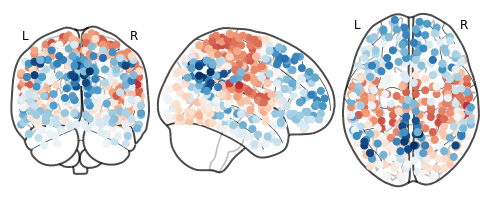

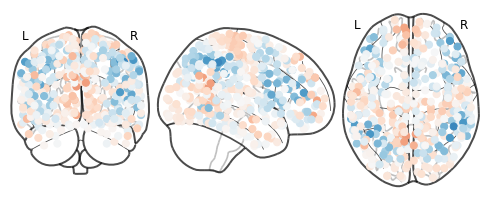

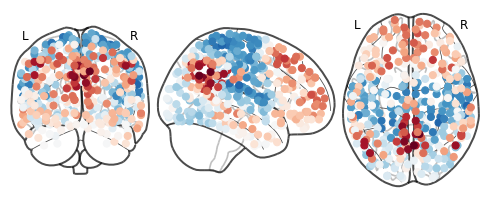

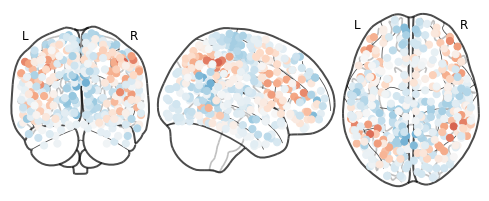

In [4]:
#Loading coordinates
coords = pd.read_csv('/home/iga/BrainStates/brain-states/Analysis/atlas/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv')
schaefer_coords = np.stack((coords.iloc[0: ,2], coords.iloc[0:, 3], coords.iloc[0:, 4])).T

#Plotting activation for 4 states
norm = plt.Normalize(vmin = mean_bs_4.min(), vmax = mean_bs_4.max())

for i in range(4):
    colors = plt.cm.RdBu_r(norm(mean_bs_4[i]))
    plotting.plot_connectome(np.zeros((400,400)), schaefer_coords, node_color = colors, display_mode ='ortho')
    plt.savefig(f'Figures/glassbrain_state_{i}.png', dpi=300, bbox_inches='tight')

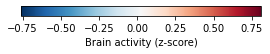

In [75]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(4.3, 1))
fig.subplots_adjust(bottom=0.75)

cmap = mpl.cm.RdBu_r
norm = mpl.colors.Normalize(vmin = mean_bs_4.min(), vmax = mean_bs_4.max())

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='Brain activity (z-score)')
plt.savefig(f'Figures/colorbar_activity.png', dpi=300, bbox_inches='tight')

### Step 4: Loading functions to correlate states with brain networks ###

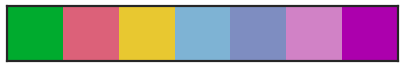

In [10]:
# #Importing functions
from brain_states.figures import get_pallette_schaefer400, get_seaborn_style

get_seaborn_style()
networks, network_pal = get_pallette_schaefer400()

### Step 5: Correlating states with brain networks ###

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


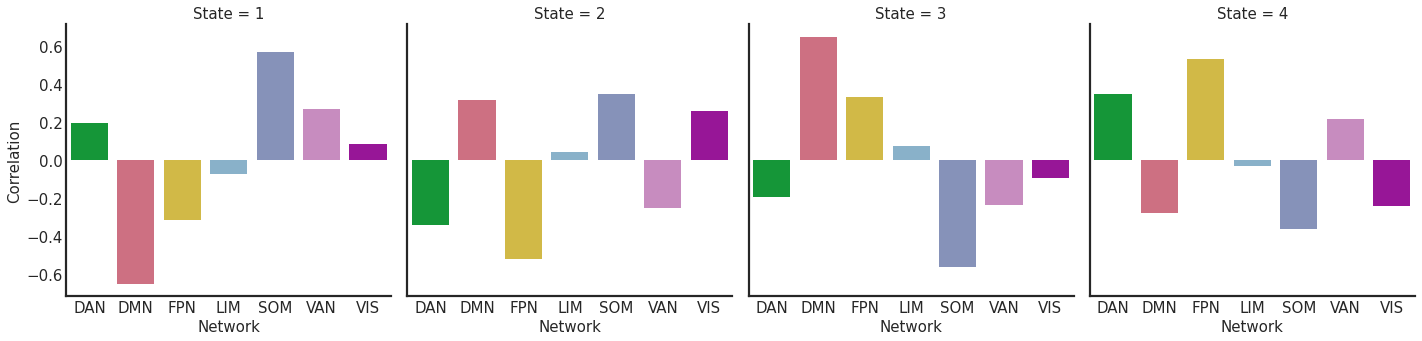

In [11]:
# Creating data frame with dummy codes for each network
networks_binary_4 = pd.get_dummies(networks)
networks_correlations_4 = pd.DataFrame()

#Calculating correlation
for k in range(states_no_4):
    for j, net in enumerate(networks_binary_4.columns):
        correlation_4 = pearsonr(mean_bs_4[k], (networks_binary_4.iloc[:,j].values))[0]
        networks_correlations_4 = pd.concat([networks_correlations_4, pd.DataFrame({"State":k+1, 
                                                                                "Network": net, 
                                                                                "Correlation": correlation_4
                                                                               },index=[0])],axis=0)

#Saving dataframe with correlations
networks_correlations_4.to_csv(r'data/fixed_networks_correlations_4.csv', index = False) 

#Plotting the correlation    
p_4 = sns.catplot(x = 'Network', y = 'Correlation', col = 'State', kind = 'bar', col_wrap = 4, data = networks_correlations_4, palette = network_pal)
plt.savefig('Figures/network_corr.png', dpi=300, bbox_inches='tight')

### Step 7: Plotting network correlations on spider/radar plots ###

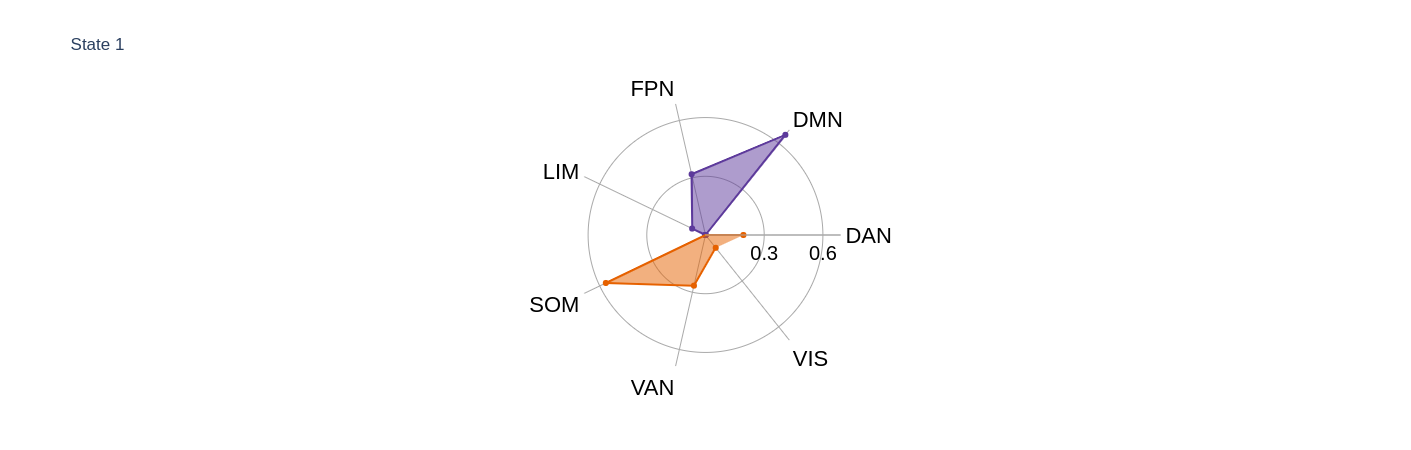

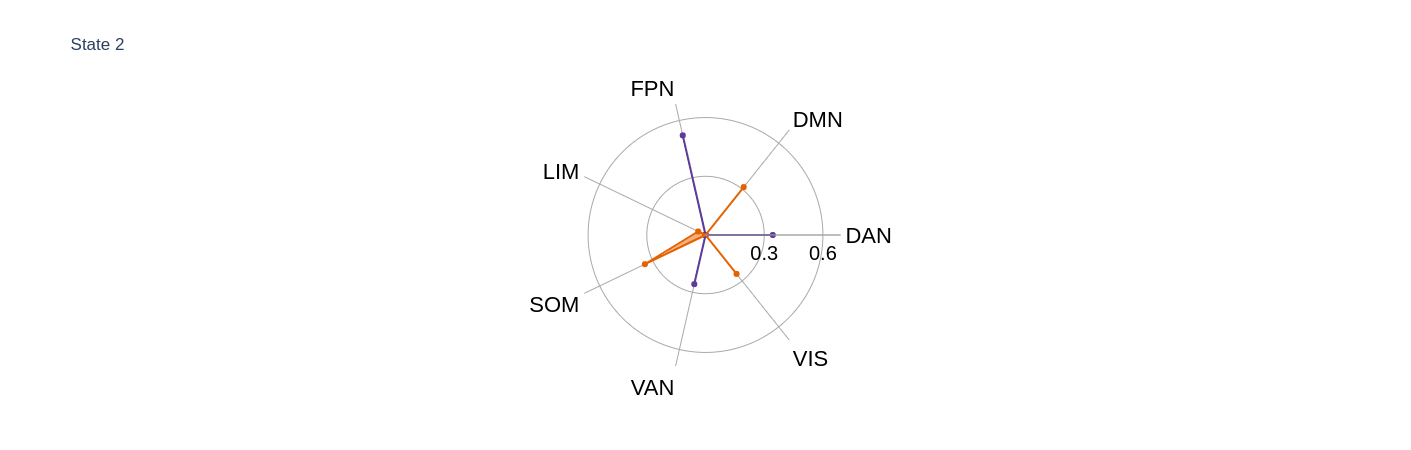

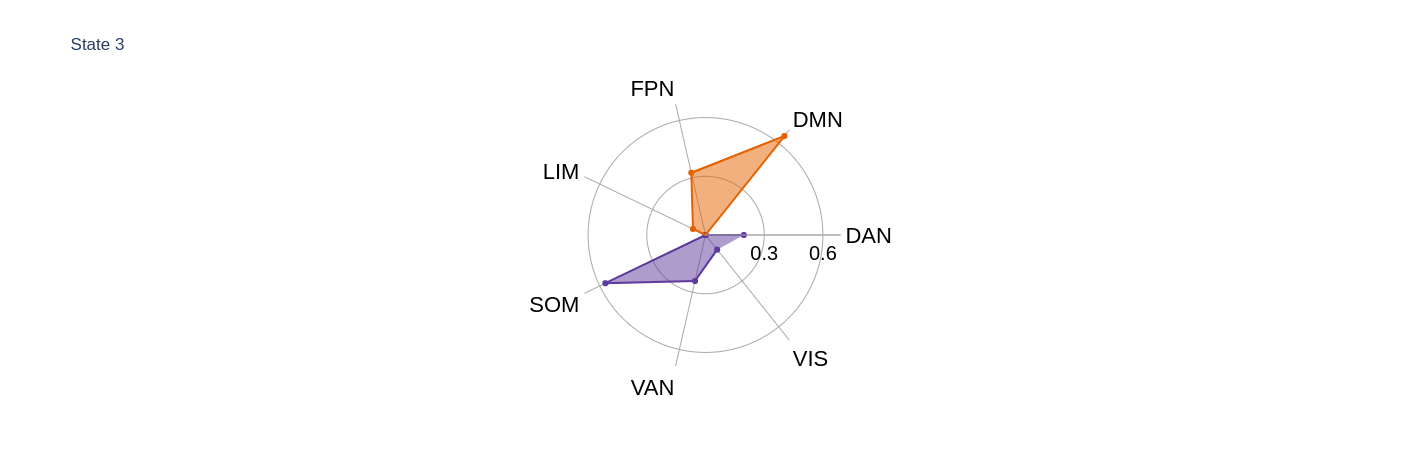

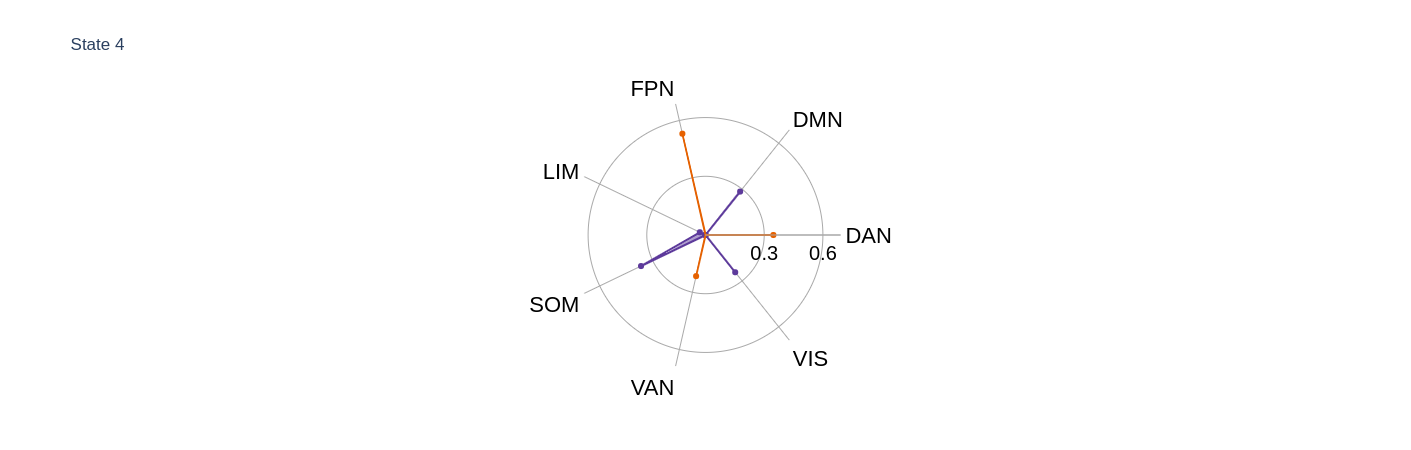

In [81]:
#Loading data
data_4 = pd.read_csv('data/fixed_networks_correlations_4.csv')

#Calculating negative correlation
corr_neg_4 = []

for i in range(0,28):
    corr_4 = data_4.iloc[i]['Correlation']
    if corr_4 < 0:
        corr_neg_4.append(abs(corr_4))
    else:
        corr_neg_4.append(0)

#Updating data
data_4['Correlation_neg'] = corr_neg_4

#Plotting networks correlations
networks_names = ['DAN','DMN', 'FPN','LIM', 'SOM', 'VAN', 'VIS']

for i in range(1,5):
    state_data_4 = data_4.where(data_4['State'] == i).dropna()
    corr_pos = np.array(state_data_4['Correlation'])
    corr_neg = np.array(state_data_4['Correlation_neg'])
        
    fig = go.Figure()

    fig.add_trace(go.Scatterpolar(r= corr_neg, theta = networks_names, fill='toself',name='Low amplitude brain state activity', line_color = '#5D3A9B'))
    fig.add_trace(go.Scatterpolar(r= corr_pos, theta = networks_names, fill='toself', name='High amplitude brain state activity', line_color = '#E66100'))

    fig.update_layout(polar=dict(bgcolor = '#ffffff', radialaxis=dict(visible=True,range=[0,0.69], color = '#000000', gridcolor = '#A9A9A9',  linecolor = '#A9A9A9', showline = True, tickvals = [0.3, 0.6], tickfont = dict(size = 20, color = '#000000')), angularaxis = dict(visible = True, categoryorder = 'category ascending', color = '#000000', showgrid = True, gridcolor = '#A9A9A9', tickfont = dict(size = 22))),showlegend = False,title = f'State {i}')
   
    fig.update_layout(width = 600)
    fig.update_layout(height= 450)
    fig.show()

### Step 8: Creating function to visualize brain networks ###

In [11]:
def get_roi_colors():
    
    #Loading data
    schaefer_400_7 = pd.read_csv('/home/iga/BrainStates/brain-states/Analysis/atlas/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv')
    roi_labels = schaefer_400_7['ROI Name']
    
    # Dictionary to create network's abbreviations
    schaefer_dict = {
        "Vis": "VIS",
        "SomMot": "SOM",
        "DorsAttn": "DAN",
        "Sal": "VAN",
        "Limbic": "LIM",
        "Cont": "FPN",
        "Default": "DMN"
    }
    
    networks_7 = []
    
    for roi in roi_labels:
        for i in schaefer_dict:
            if i in roi:
                networks_7.append(schaefer_dict[i])
                
    #Adding new column to the dictionary
    schaefer_400_7['Network'] = networks_7
    
    # Creating color palette for netorks
    schaefer_colors = {'DAN':'#00ab2e', 
                       'DMN':'#dc6179', 
                       'FPN':'#e8c830',
                       'LIM':'#7eb3d4', 
                       'SOM':'#7e8dc1', 
                       'VAN':'#d182c6',
                       'VIS':'#ac00ad',}
    
    #Getting color corresponding to network for each ROI
    schaefer_400_7['Colors'] = schaefer_400_7['Network'].map(schaefer_colors)
    
    return schaefer_400_7

### Step 9: Running function to visualize brain networks ###

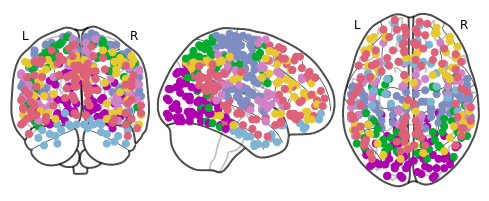

In [13]:
df = get_roi_colors()
colors = df['Colors']
roi_colors = list(colors)

plotting.plot_connectome(np.zeros((400,400)), schaefer_coords, node_color = roi_colors, display_mode ='ortho')
plt.savefig(f'Figures/Schaefer.png', dpi=300, bbox_inches='tight')